In [1]:
%matplotlib inline
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from SAMPEX_functions import read_counts as read
from SAMPEX_functions import mb_finder, read_days, mb_magnitude, iso_calculator, OrbAtt_augment
import pandas as pd
import os
import pathlib
import string
import datetime

# Read in Data

In [2]:
# defining file
year = '1993'
start_day = '047'
num_days = 7
month = (datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(start_day)-1)).month
day = (datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(start_day)-1)).day

In [3]:
# code is specific for year 1993
OrbAtt_names = np.array(['OrbAtt_secofyear_1993001-1993012.txt', 'OrbAtt_secofyear_1993013-1993039.txt', 'OrbAtt_secofyear_1993040-1993066.txt', \
                         'OrbAtt_secofyear_1993067-1993093.txt', 'OrbAtt_secofyear_1993094-1993120.txt', 'OrbAtt_secofyear_1993121-1993147.txt', \
                         'OrbAtt_secofyear_1993148-1993174.txt', 'OrbAtt_secofyear_1993175-1993201.txt', 'OrbAtt_secofyear_1993202-1993228.txt', \
                         'OrbAtt_secofyear_1993229-1993255.txt', 'OrbAtt_secofyear_1993256-1993282.txt', 'OrbAtt_secofyear_1993283-1993309.txt', \
                         'OrbAtt_secofyear_1993310-1993336.txt', 'OrbAtt_secofyear_1993337-1993363.txt', 'OrbAtt_secofyear_1993364-1993365.txt'])

In [4]:
# set end_day
if int(start_day[1]) < 9 or int(start_day[2]) < 4:
    if start_day[0] != '0':
        end_day = str(int(start_day) + (num_days-1))
    elif start_day[0] == '0' and start_day[1] != '0':
        end_day = '0' + str(int(start_day) + (num_days-1))
    elif start_day[0] == '0' and start_Day[1] == '0':
        end_day = '00' + str(int(start_day) + (num_days-1))
elif int(start_day[1]) >= 9 or int(start_day[2]) >= 4:
    end_day = str(int(start_day) + (num_days-1))

In [5]:
# reading in electron counts files:
t, r1, r2, r3, r4 = read_days(year, start_day, num_days, month)

In [6]:
# find microburst times and N_100, SSD1, SSD4 counts using algorithm
t_microburst, N_100_microburst, r1_microburst, r4_microburst, mb_index, MB_mask, N_100, A_500 = mb_finder(t, r1, r2, r3, r4)

In [7]:
BG_mask = ~MB_mask

# calculation of the isotropy indices of electron counts
iso_indices_MB = iso_calculator(r1[MB_mask], r4[MB_mask])
iso_indices_BG = iso_calculator(r1[BG_mask], r4[BG_mask])

In [8]:
# reading in orbit/attitude data file
directory = 'D:\SAMPEX_Data\\'
OA_file = 'OrbAtt_' + year + start_day + '-' + year + end_day + '.txt'
OrbAtt_data = pd.read_csv(directory + OA_file, names = ['sec_of_day', 'GEO_Radius', 'GEO_Long', 'GEO_Lat', 'Altitude', 'L_Shell', 'MLT', 
                                         'SAA_Flag', 'Pitch', 'zenith', 'azimuth', 'Att_Flag'], sep = '\s+', header = 70)

t_OrbAtt, LS_OrbAtt, MLT_OrbAtt, P_OrbAtt, Lat_OrbAtt, Long_OrbAtt, R_OrbAtt = OrbAtt_augment(t, OrbAtt_data, num_days)

t_OrbAtt_mb = t_OrbAtt[mb_index]; LS_OrbAtt_mb = LS_OrbAtt[mb_index]; MLT_OrbAtt_mb = MLT_OrbAtt[mb_index];
P_OrbAtt_mb = P_OrbAtt[mb_index]; Lat_OrbAtt_mb = Lat_OrbAtt[mb_index]; Long_OrbAtt_mb = Long_OrbAtt[mb_index];
R_OrbAtt_mb = R_OrbAtt[mb_index]

In [9]:
# defining month
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# reading in magnetosphere indices
file = 'mag_indices_' + month_list[month-1] + year + start_day + '.csv'
Mag_Indices = pd.read_csv(directory + file, header = 0, comment = '#')

AE_indices = Mag_Indices['5-M_AE_nT'].values
Dst_indices = Mag_Indices['SYM/H_INDEX_nT'].values

t_str = Mag_Indices['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'].values
t_mag = np.array([])

for i in np.arange(len(t_str)):
    if t_str[i][5:7] != t_str[0][5:7]:
        days_in_month = input('Days in the first month: ')
        break
    
for i in np.arange(len(t_str)):
    if t_str[i][5:7] == t_str[0][5:7]:
        t_i = (int(t_str[i][8:10])-int(t_str[0][8:10])) * 86400 + int(t_str[i][11:13]) * 3600 + int(t_str[i][14:16]) * 60
    elif t_str[i][5:7] != t_str[0][5:7]:
        t_i = (int(days_in_month) + int(t_str[i][8:10])-int(t_str[0][8:10])) * 86400 + int(t_str[i][11:13]) * 3600 + \
        int(t_str[i][14:16]) * 60
    t_mag = np.append(t_mag, t_i)

In [10]:
# define pic_directory
pic_directory = 'C:\\Users\\jacob\\Documents\\CU_Boulder\\Fall2020\\Research\\LASP Research\\Lauren Blum\\GMS Catalog\\' + year + '\\' + year + start_day + '-' + year + end_day + '\\'

# create new folder if it does not exist
if os.path.isdir(pic_directory) == False:
    os.mkdir(pic_directory)

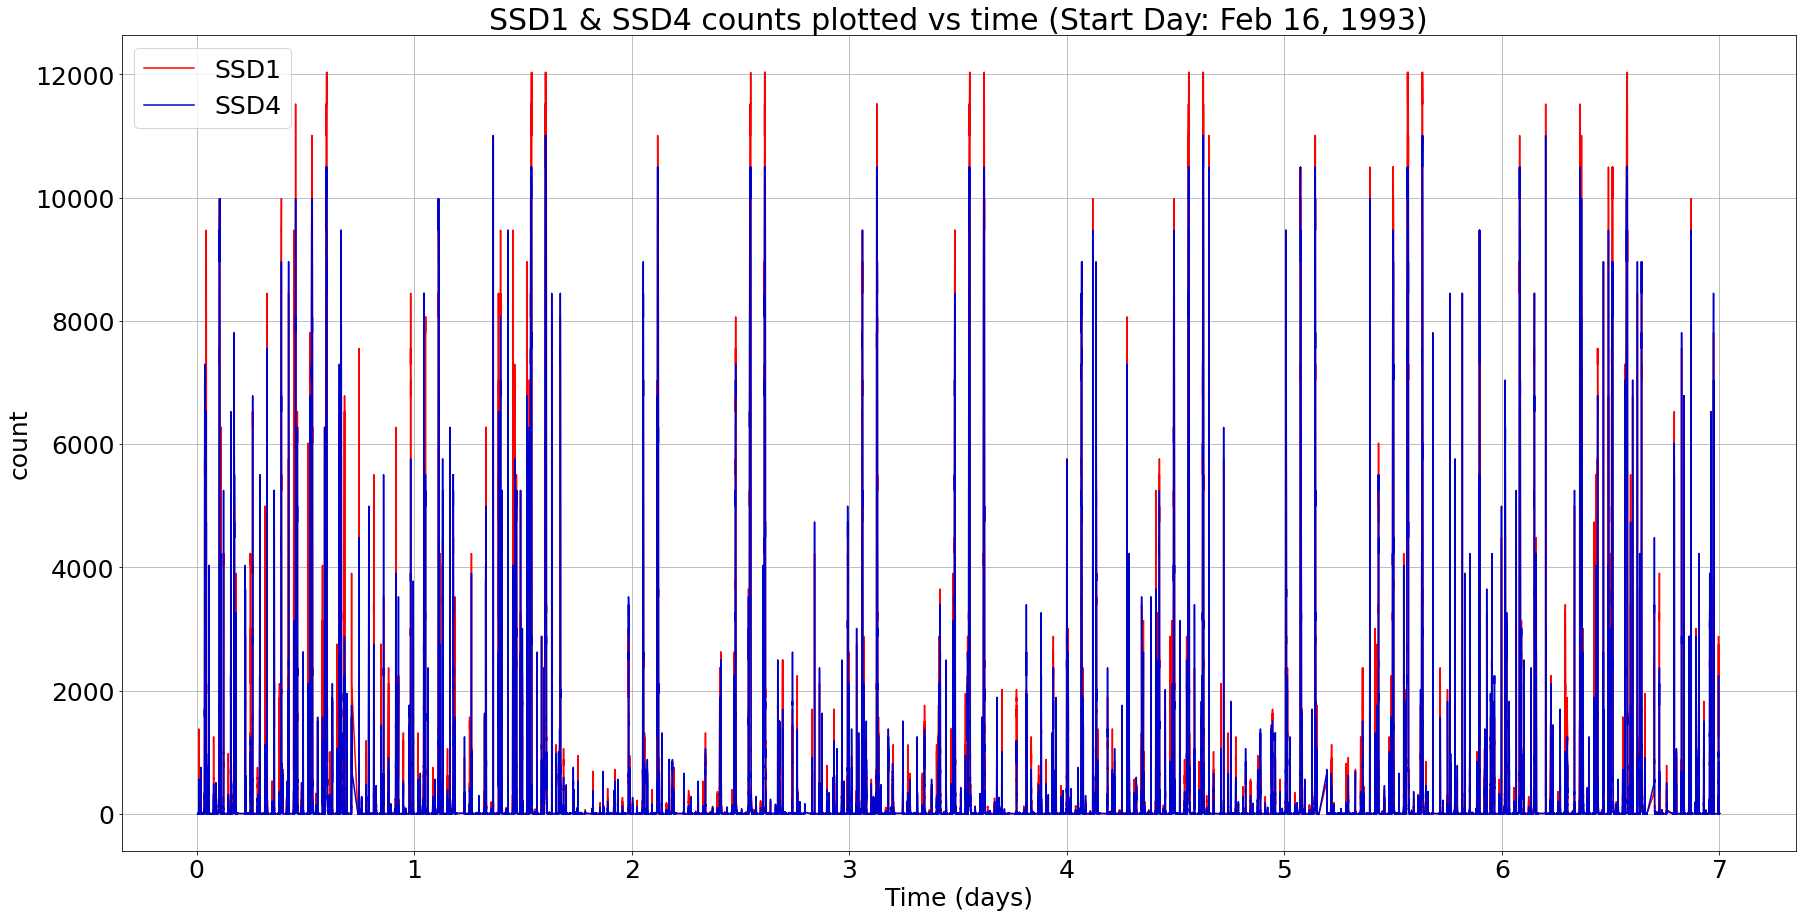

In [11]:
# plotting electron counts on a linear plot
x_ticks = np.linspace(0, num_days*86400, num_days+1)
x_names = np.arange(0, num_days+1)

plt.figure(figsize = (30,15))
plt.title(f'SSD1 & SSD4 counts plotted vs time (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.plot(t, r1, 'Red', t, r4, 'MediumBlue')
plt.xlabel('Time (days)', fontsize = 25)
plt.ylabel('count', fontsize = 25)
plt.xticks(x_ticks, x_names, fontsize = 25)
plt.yticks(fontsize = 25)
#plt.xlim(np.min(t),np.max(t))
plt.legend(['SSD1', 'SSD4'], loc = 'best', fontsize = 25)
plt.grid(True)
plt.savefig(pic_directory + 'SSD_Counts_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

# Microburst Iso vs AE/Dst

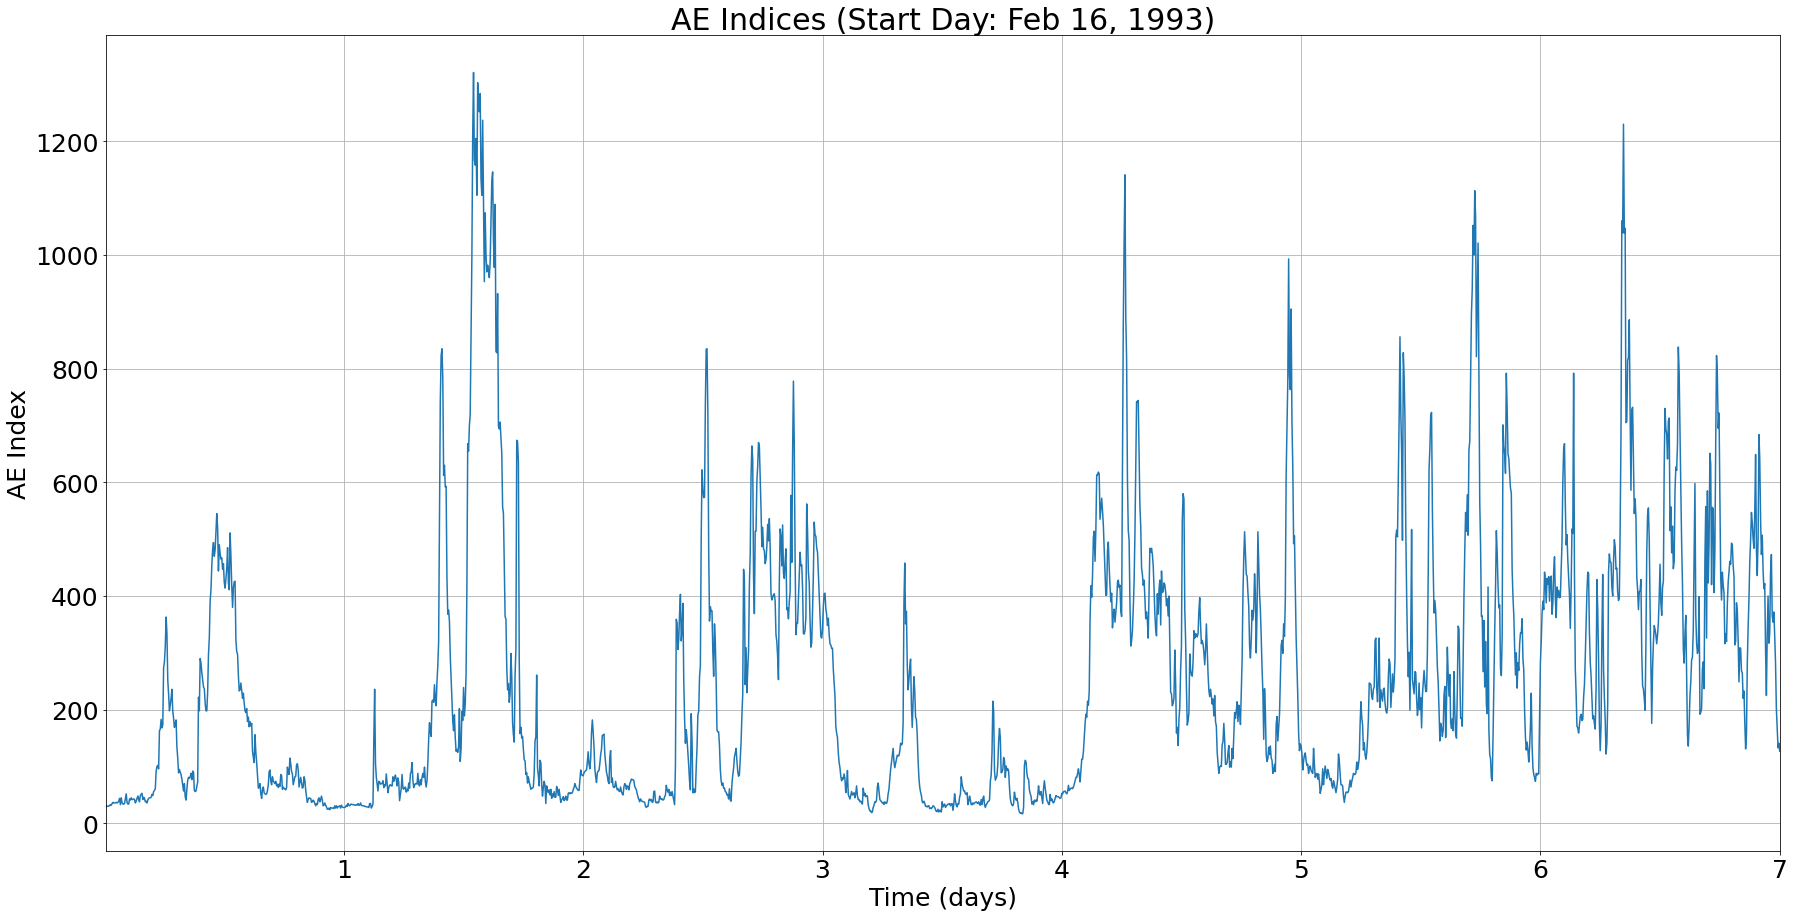

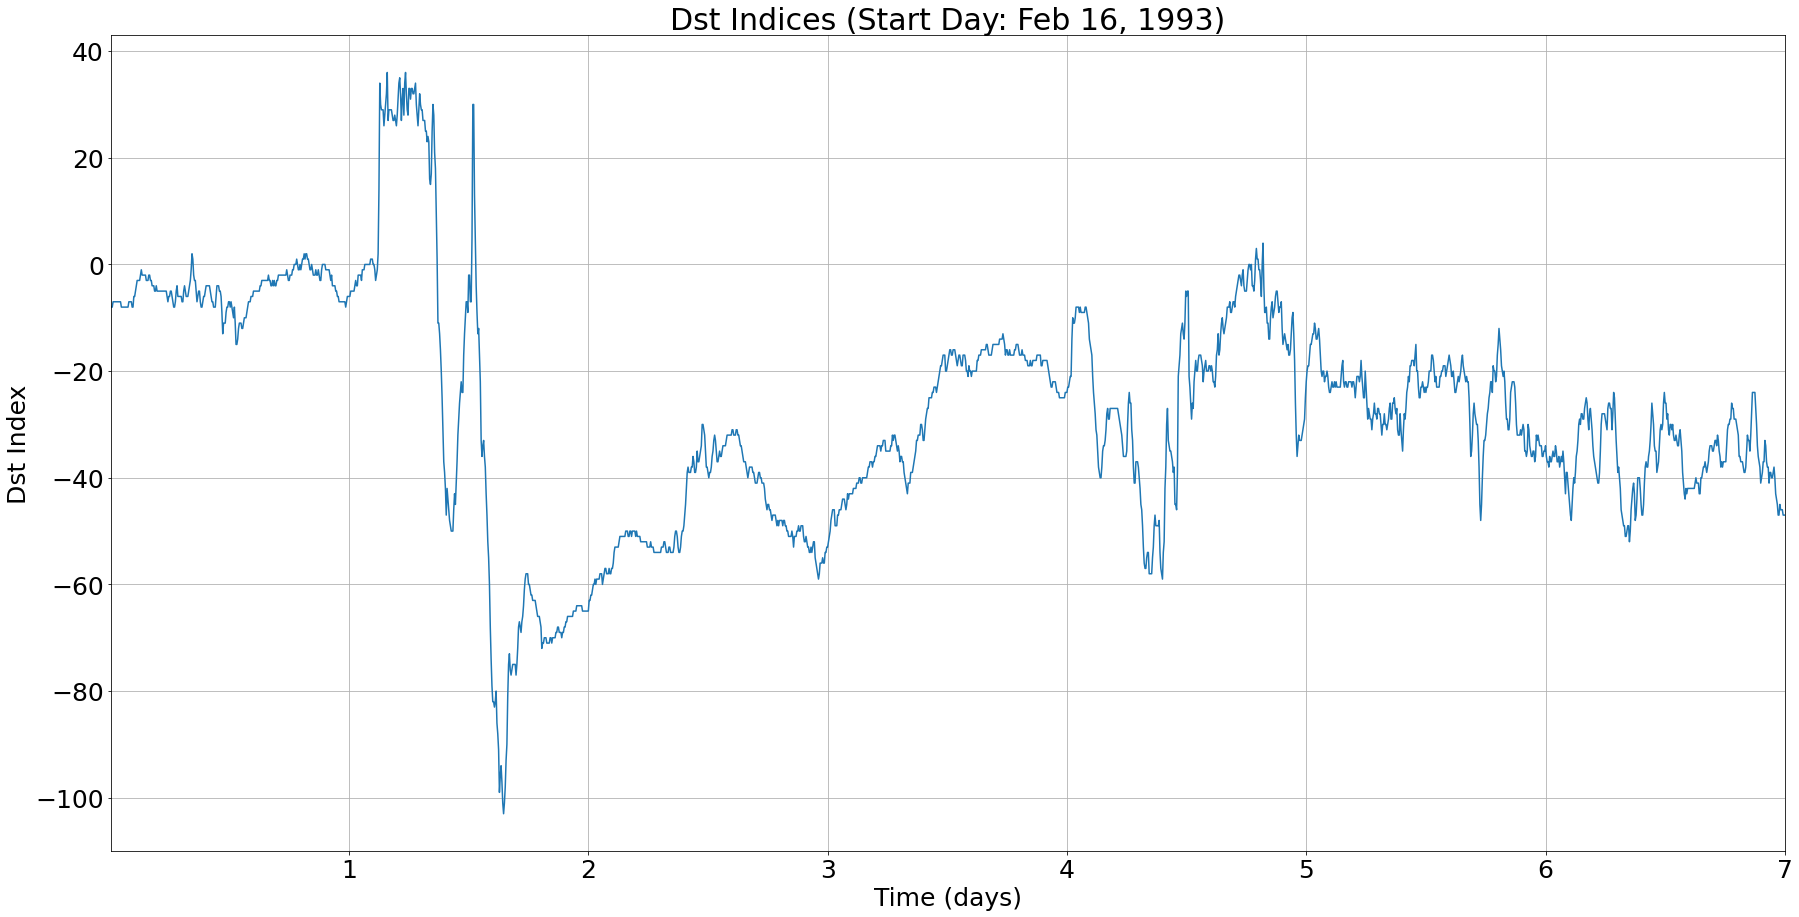

In [12]:
# plotting mag AE indices
plt.figure(figsize = (30,15))
plt.title(f'AE Indices (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.plot(t_mag, AE_indices)
plt.xlabel('Time (days)', fontsize = 25)
plt.ylabel('AE Index', fontsize = 25)
plt.xticks(x_ticks, x_names, fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlim(np.min(t),np.max(t))
plt.grid(True)
plt.savefig(pic_directory + 'AE_Indices_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

# plotting mag Dst indices
plt.figure(figsize = (30,15))
plt.title(f'Dst Indices (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.plot(t_mag, Dst_indices)
plt.xlabel('Time (days)', fontsize = 25)
plt.ylabel('Dst Index', fontsize = 25)
plt.xticks(x_ticks, x_names, fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlim(np.min(t),np.max(t))
plt.grid(True)
plt.savefig(pic_directory + 'Dst_Indices_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

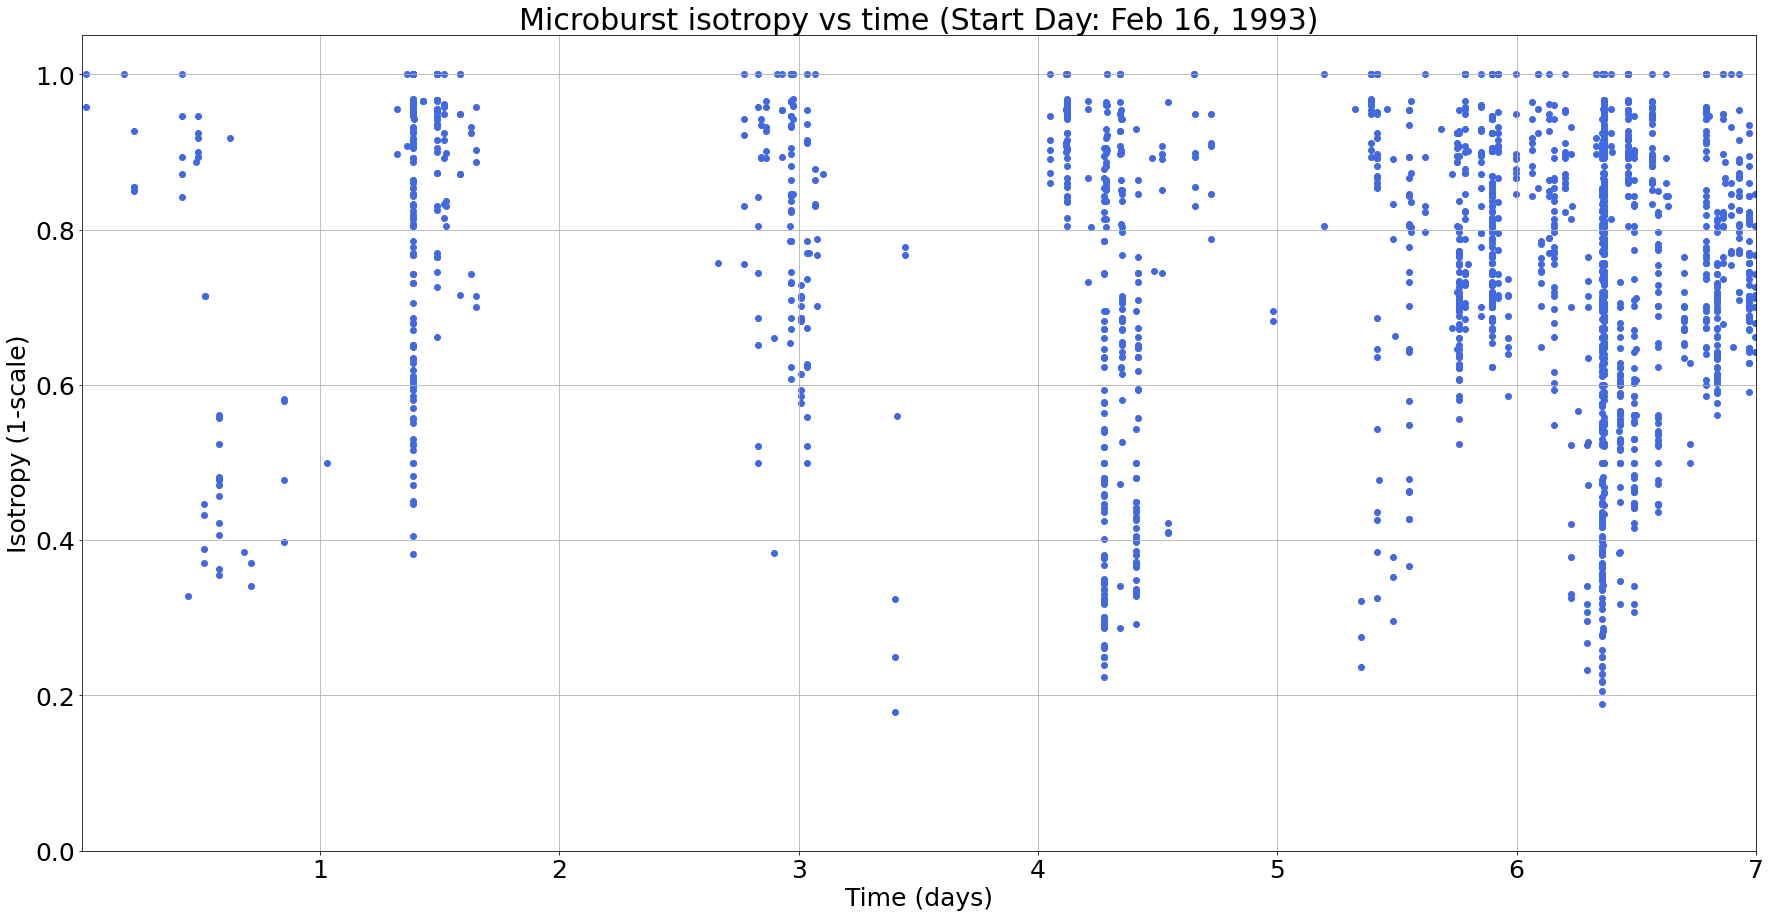

In [13]:
# isotropy plot
plt.figure(figsize = (30,15))
plt.title(f'Microburst isotropy vs time (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.scatter(t_microburst, iso_indices_MB, c = 'RoyalBlue')
plt.xlabel('Time (days)', fontsize = 25)
plt.ylabel('Isotropy (1-scale)', fontsize = 25)
plt.xticks(x_ticks, x_names, fontsize = 25)
plt.yticks(fontsize = 25)
plt.ylim(0, 1.05)
plt.xlim(np.min(t),np.max(t))
plt.grid(True)
plt.savefig(pic_directory + 'Iso_vs_Time_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

In [14]:
# Augment AE indices to fit counts data

tAE_list = np.array([])
AE_list = np.array([])

for i in np.arange(len(t_microburst)):
    diff = abs(t_mag - t_microburst[i])
    tAE_i = t_mag[diff == np.min(diff)]
    AE_i = AE_indices[diff == np.min(diff)]
    
    if sum(diff == np.min(diff)) != 1:
        tAE_i = t_mag[diff == np.min(diff)][0]
        AE_i = AE_indices[diff == np.min(diff)][0]
    
    tAE_list = np.append(tAE_list, tAE_i)
    AE_list = np.append(AE_list, AE_i)

# Parameter Frequency Analysis

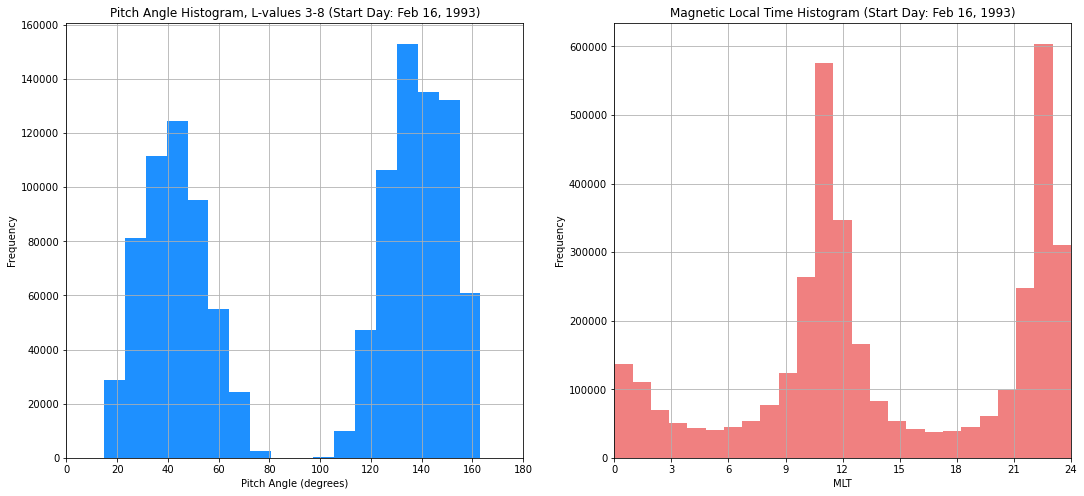

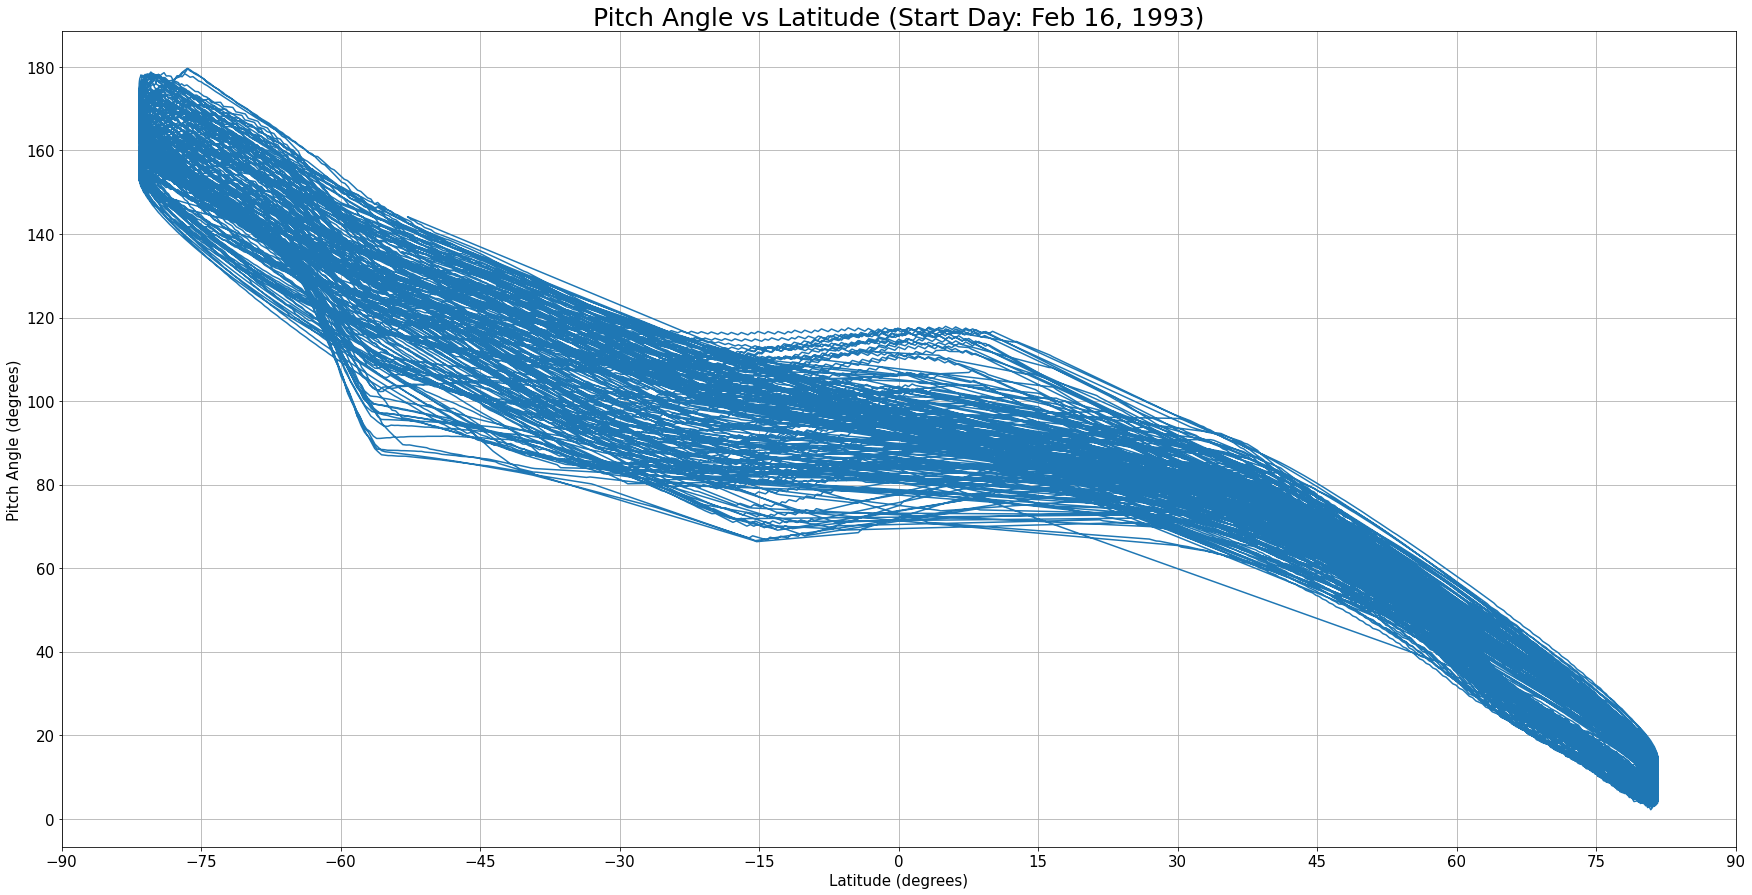

In [15]:
# create subplots
fig, axes = plt.subplots(1, 2, figsize = (18,8))
left = axes[0]
right = axes[1]

# pitch angle histogram
bin_num = 18
P_mean = np.mean(P_OrbAtt)
domain = 200

# look at only relevant L-Shells
mask = (LS_OrbAtt >= 3) & (LS_OrbAtt <= 8)

left.hist(P_OrbAtt[mask], bin_num, color = 'dodgerblue')
left.set_title(f'Pitch Angle Histogram, L-values 3-8 (Start Day: {month_list[month-1]} {day}, {year})')
left.set_xlabel('Pitch Angle (degrees)')
left.set_ylabel('Frequency')
left.set_xlim([0,180])
#left.set_ylim(None, 1000)
left.set_xticks(np.linspace(0, 180, 10))
left.grid(True)

# Magnetic Local Time histogram
bin_num = 25
MLT_mean = np.mean(MLT_OrbAtt)
domain = 26

right.hist(MLT_OrbAtt, bin_num, color = 'lightcoral')
right.set_title(f'Magnetic Local Time Histogram (Start Day: {month_list[month-1]} {day}, {year})')
right.set_xlabel('MLT')
right.set_ylabel('Frequency')
right.set_xlim([0,24])
right.set_xticks(np.linspace(0, 24, 9))
right.grid(True)

plt.savefig(pic_directory + 'Pitch_MLT_Histograms_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

# Pitch angle vs. lat plot

plt.figure(figsize = (30,15))
plt.title(f'Pitch Angle vs Latitude (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 25)
plt.plot(Lat_OrbAtt, P_OrbAtt)
plt.xlabel('Latitude (degrees)', fontsize = 15)
plt.ylabel('Pitch Angle (degrees)', fontsize = 15)
#plt.ylim(0, 20)
plt.xticks(np.linspace(-90, 90, 13), fontsize = 15)
plt.yticks(np.linspace(0, 180, 10), fontsize = 15)
plt.grid(True)

plt.savefig(pic_directory + 'Pitch_vs_Lat_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

# Microburst Iso vs Mag

In [16]:
# calculation of B_3 bin percentiles

y_microburst, B_3_microburst, B_3 = mb_magnitude(N_100, N_100_microburst, A_500)

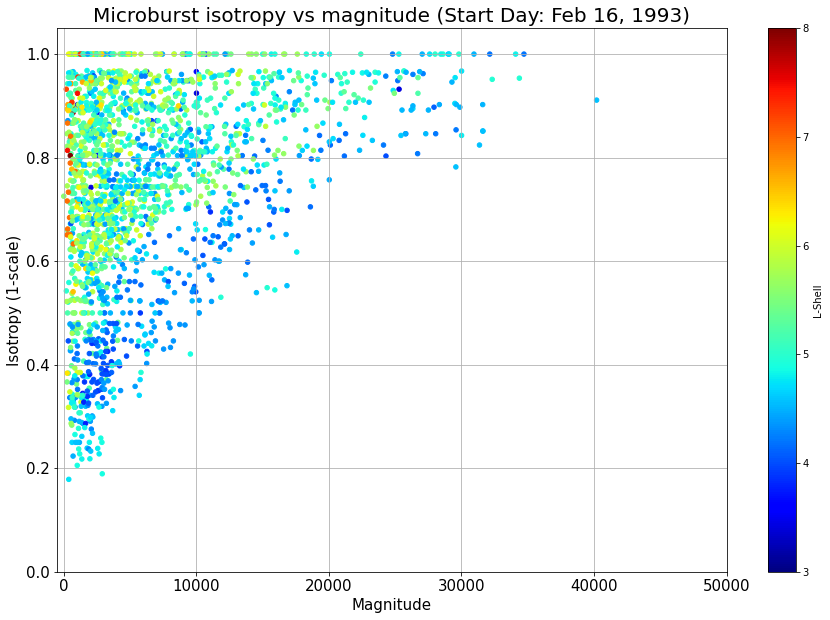

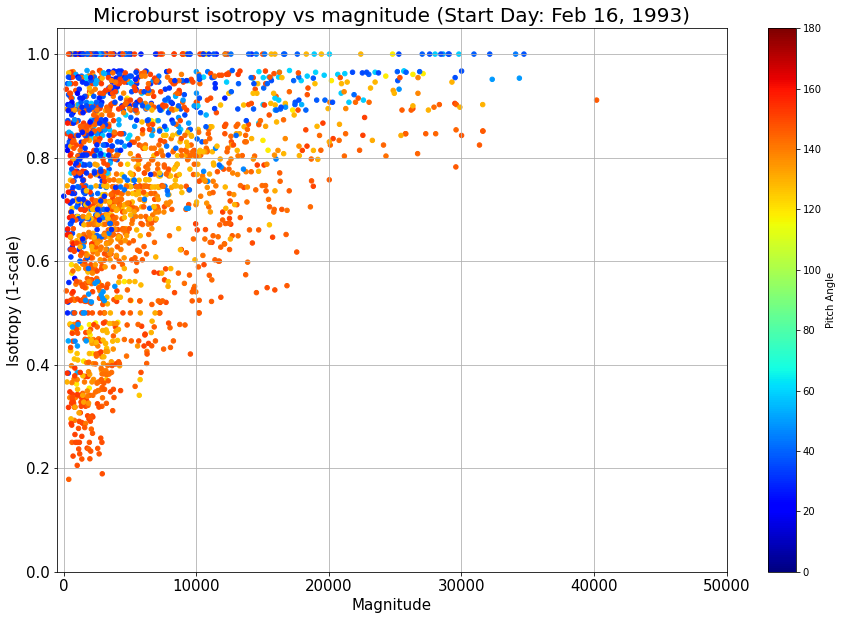

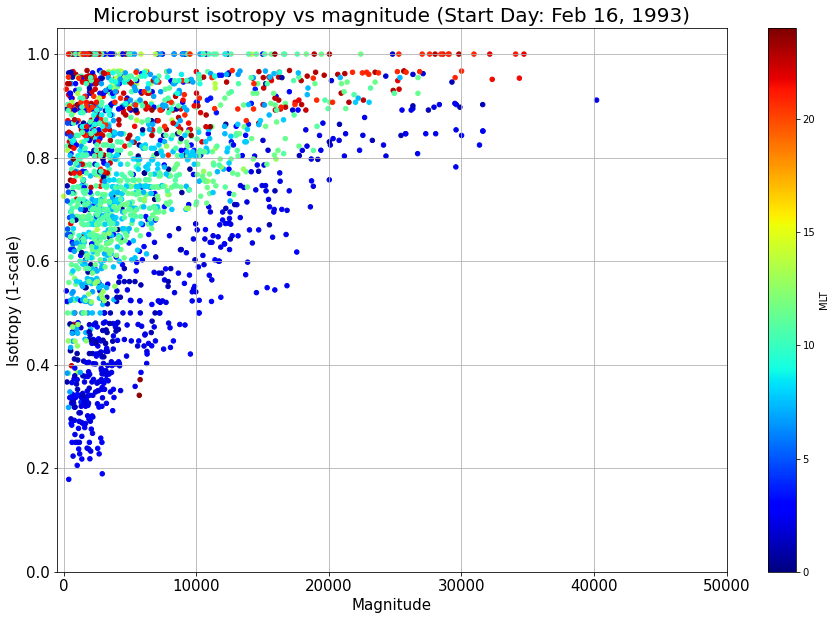

In [17]:
# plot microburst isotropy vs magnitude

plt.figure(figsize = (15,10))
plt.title(f'Microburst isotropy vs magnitude (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 20)
plt.scatter(y_microburst, iso_indices_MB, s = 20, c = LS_OrbAtt_mb, cmap=plt.cm.get_cmap('jet'))
plt.xlabel('Magnitude', fontsize = 15)
plt.ylabel('Isotropy (1-scale)', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim(-500, 50000)
plt.ylim(0, 1.05)
plt.grid(True)
plt.clim(3,8)
plt.colorbar(label='L-Shell')
plt.savefig(pic_directory + 'Iso_vs_MagLS_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

plt.figure(figsize = (15,10))
plt.title(f'Microburst isotropy vs magnitude (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 20)
plt.scatter(y_microburst, iso_indices_MB, s = 20, c = P_OrbAtt_mb, cmap=plt.cm.get_cmap('jet'))
plt.xlabel('Magnitude', fontsize = 15)
plt.ylabel('Isotropy (1-scale)', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim(-500, 50000)
plt.ylim(0, 1.05)
plt.grid(True)
plt.clim(0, 180)
plt.colorbar(label='Pitch Angle')
plt.savefig(pic_directory + 'Iso_vs_MagP_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

plt.figure(figsize = (15,10))
plt.title(f'Microburst isotropy vs magnitude (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 20)
plt.scatter(y_microburst, iso_indices_MB, s = 20, c = MLT_OrbAtt_mb, cmap=plt.cm.get_cmap('jet'))
plt.xlabel('Magnitude', fontsize = 15)
plt.ylabel('Isotropy (1-scale)', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim(-500, 50000)
plt.ylim(0, 1.05)
plt.grid(True)
plt.clim(0, 24)
plt.colorbar(label='MLT')
plt.savefig(pic_directory + 'Iso_vs_MagMLT_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

# Magnitude/Iso vs Pitch/LS

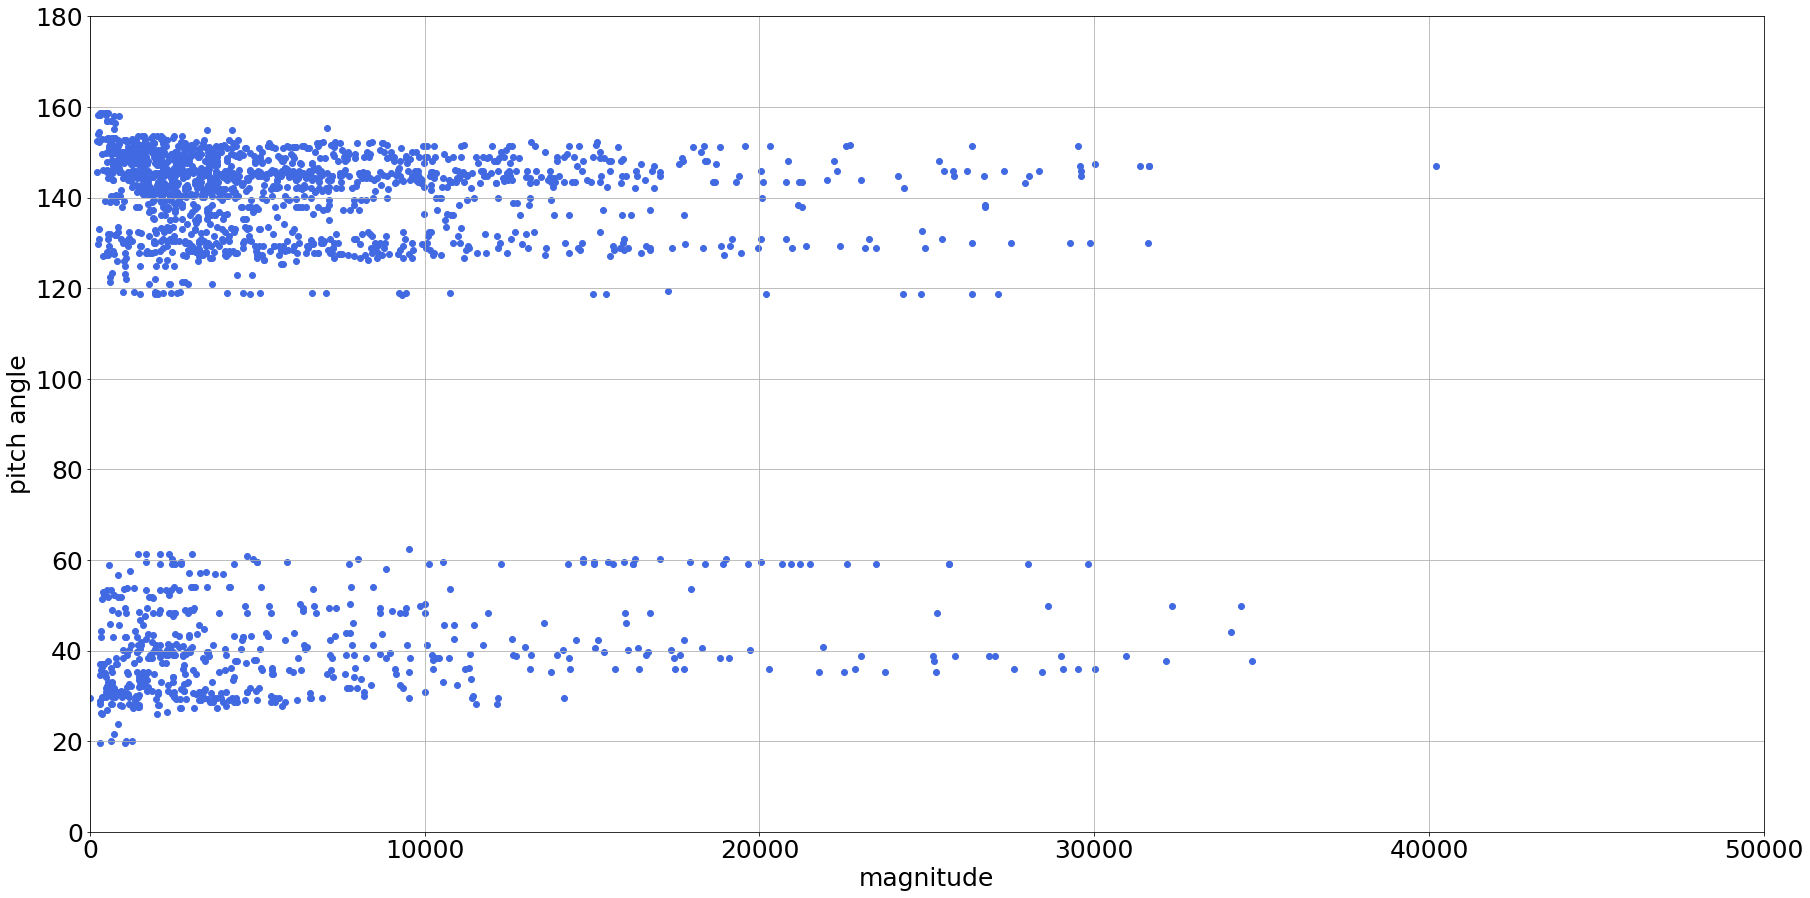

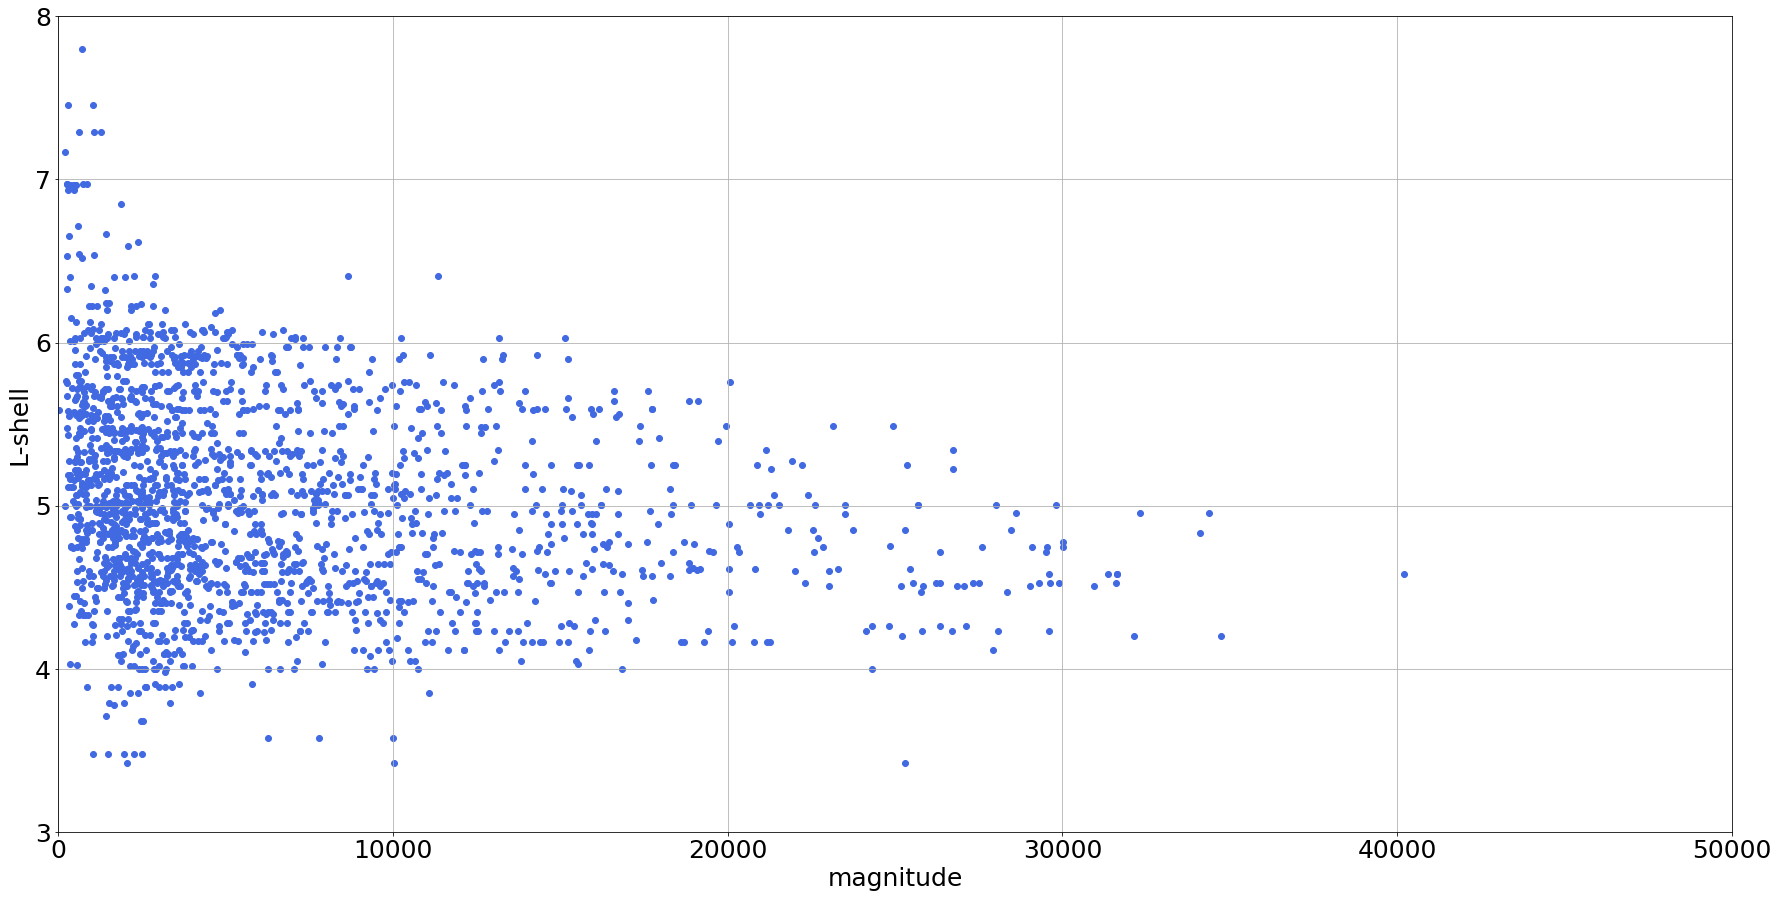

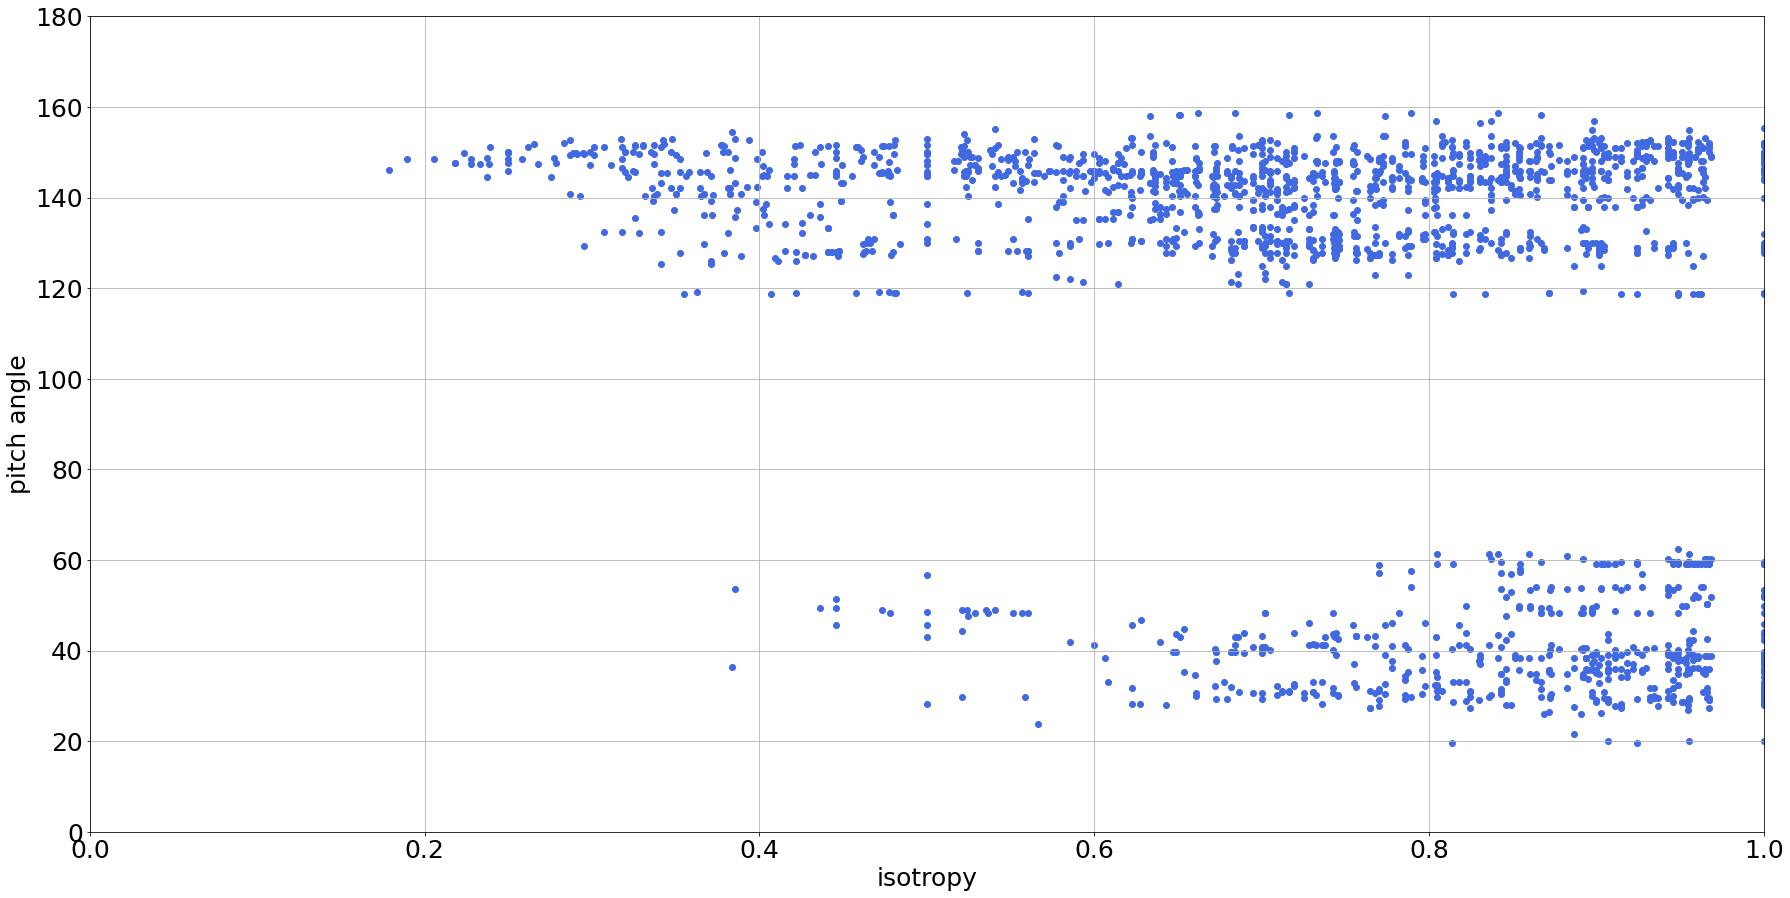

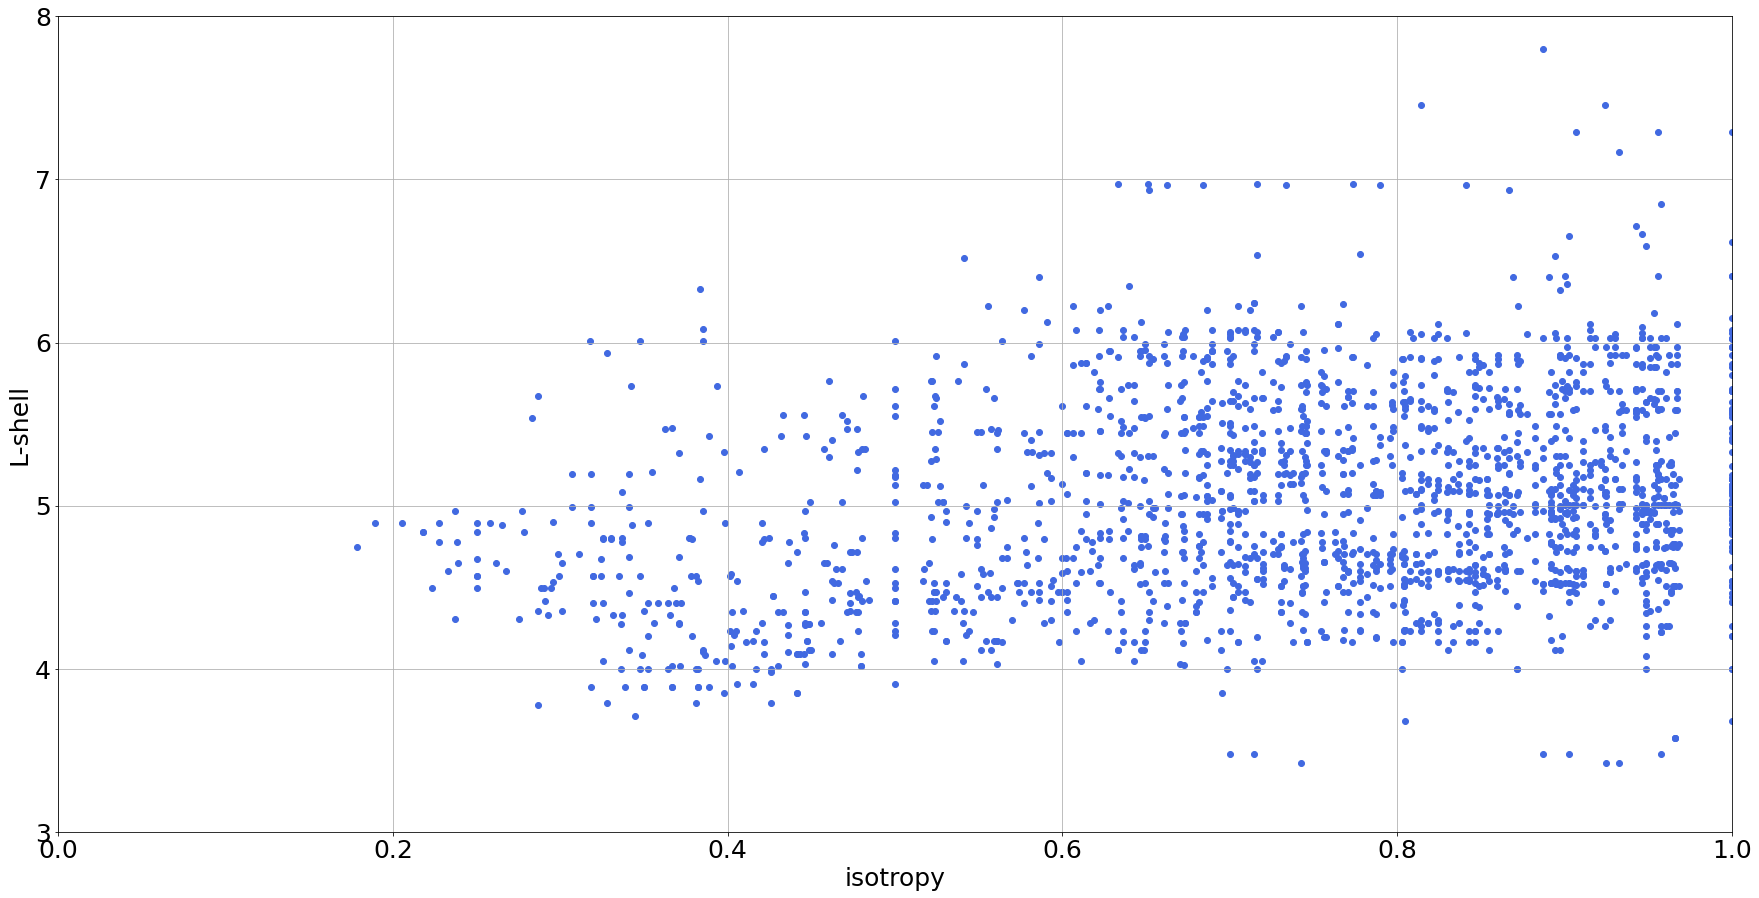

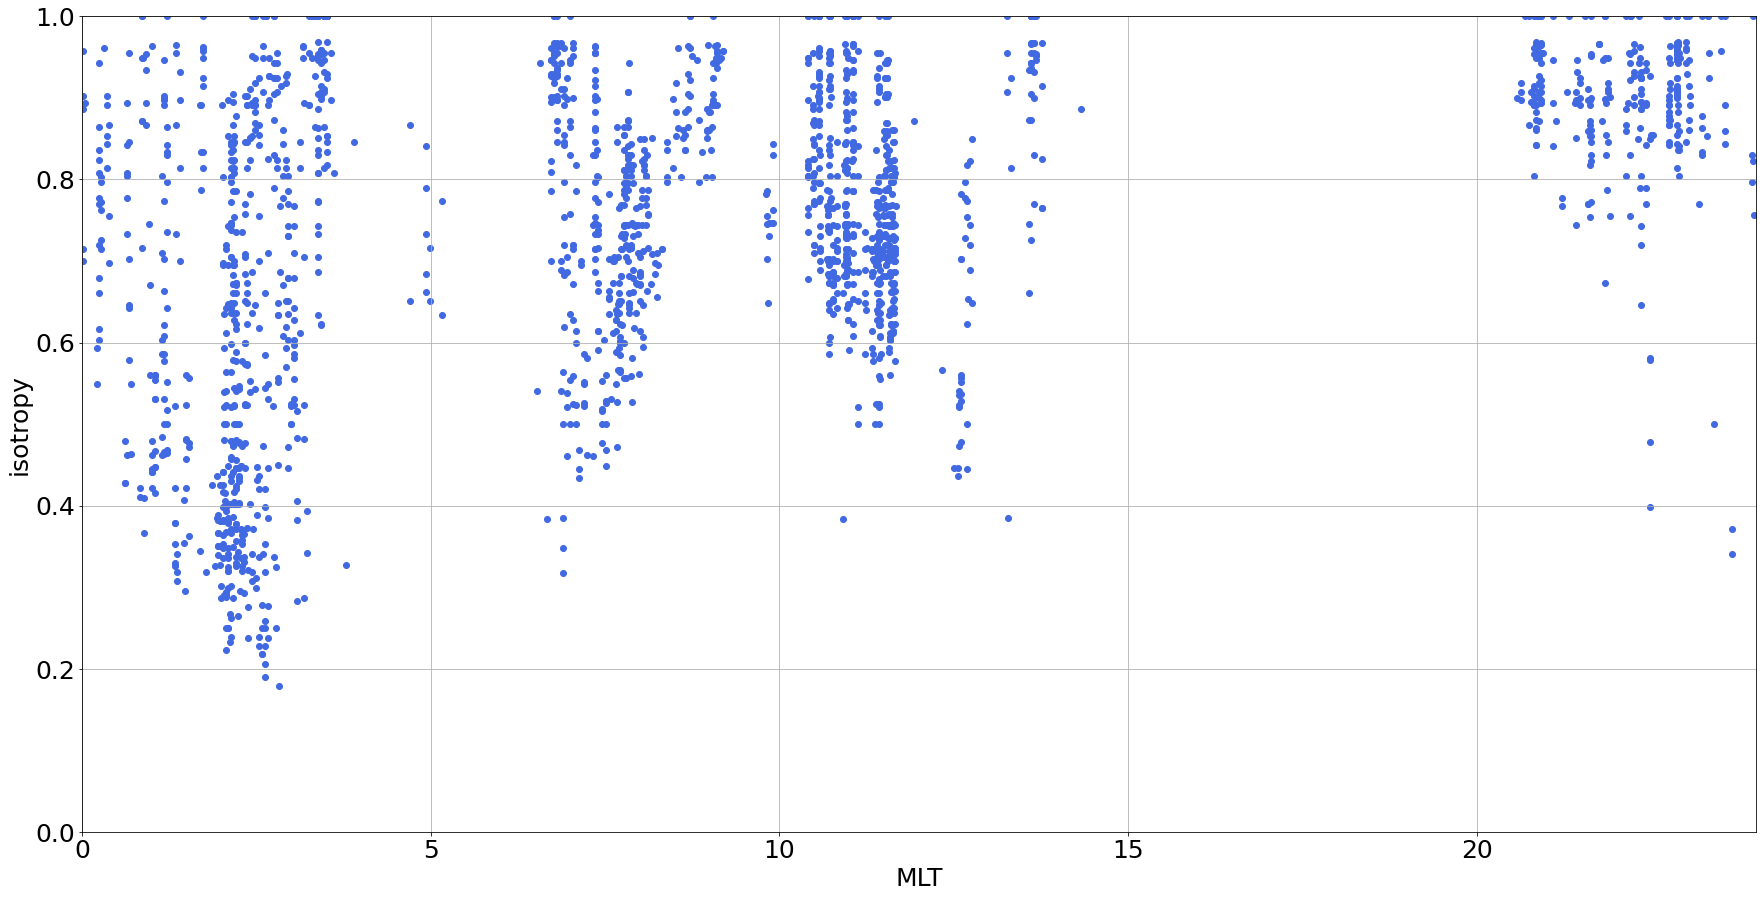

In [18]:
# magnitude vs.:

plt.figure(figsize = (30,15))
#plt.title(f'Microburst isotropy vs time (Year: {year}, Start Day: {start_day})', fontsize = 30)
plt.scatter(y_microburst, P_OrbAtt_mb, c = 'RoyalBlue')
plt.xlabel('magnitude', fontsize = 25)
plt.ylabel('pitch angle', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.ylim(0, 180)
plt.xlim(0,50000)
plt.grid(True)

plt.figure(figsize = (30,15))
#plt.title(f'Microburst isotropy vs time (Year: {year}, Start Day: {start_day})', fontsize = 30)
plt.scatter(y_microburst, LS_OrbAtt_mb, c = 'RoyalBlue')
plt.xlabel('magnitude', fontsize = 25)
plt.ylabel('L-shell', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.ylim(3, 8)
plt.xlim(0,50000)
plt.grid(True)

# isotropy vs.:

plt.figure(figsize = (30,15))
#plt.title(f'Microburst isotropy vs time (Year: {year}, Start Day: {start_day})', fontsize = 30)
plt.scatter(iso_indices_MB, P_OrbAtt_mb, c = 'RoyalBlue')
plt.xlabel('isotropy', fontsize = 25)
plt.ylabel('pitch angle', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.ylim(0, 180)
plt.xlim(0, 1)
plt.grid(True)

plt.figure(figsize = (30,15))
#plt.title(f'Microburst isotropy vs time (Year: {year}, Start Day: {start_day})', fontsize = 30)
plt.scatter(iso_indices_MB, LS_OrbAtt_mb, c = 'RoyalBlue')
plt.xlabel('isotropy', fontsize = 25)
plt.ylabel('L-shell', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.ylim(3, 8)
plt.xlim(0,1)
plt.grid(True)

plt.figure(figsize = (30,15))
#plt.title(f'Microburst isotropy vs time (Year: {year}, Start Day: {start_day})', fontsize = 30)
plt.scatter(MLT_OrbAtt_mb, iso_indices_MB, c = 'RoyalBlue')
#plt.scatter(MLT_OrbAtt_mb, y_microburst, c = 'RoyalBlue')
plt.xlabel('MLT', fontsize = 25)
plt.ylabel('isotropy', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.ylim(0, 1)
#plt.ylim(0,50000)
plt.xlim(0,24)
plt.grid(True)